## Figure 8: Back-Prop Trained network

This notebook generates figure 8 from 'Meta-Learning the Inductive Bias of Simple Neural Circuits', Dorrell et al. 2022.

We learn six orthogonal functions that a simple ReLU network trained by gradient descent learns.

Very slight perturbations on this code were used to generate figure 11.

In [1]:
# Import Things
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from geomloss import SamplesLoss  # See also ImagesLoss, VolumesLoss

In [2]:
# A coupl of useful functions
# Function to generate N datapoints on the sphere
def new_data(N):
    x = torch.normal(0,1,[N,3])
    return x/torch.norm(x, dim = 1)[:,np.newaxis]

# Function to map points on sphere to 2D
def threeto2D(x):
    y = np.zeros([x.shape[0], 2])
    y[:,0] = np.arctan2(x[:,1],x[:,0])+torch.pi
    y[:,1] = np.arctan2(x[:,2],np.sqrt(np.power(x[:,0],2) + np.power(x[:,1],2)))+torch.pi/2
    return y

In [10]:
# Define the neural networks
# Our meta-learner class
class MetaNet(nn.Module):
    def __init__(self,input_size_gen,hidden_size_gen, output_size_gen, layers):
        super(MetaNet,self).__init__()
        self.linear1 = nn.Linear(input_size_gen,hidden_size_gen, bias = True)
        self.linearh1 = nn.Linear(hidden_size_gen,hidden_size_gen, bias = True)
        self.linearh2 = nn.Linear(hidden_size_gen,hidden_size_gen, bias = True)
        self.linearh3 = nn.Linear(hidden_size_gen,hidden_size_gen, bias = True)
        self.linearh4 = nn.Linear(hidden_size_gen,hidden_size_gen, bias = True)
        self.linear3 = nn.Linear(input_size_gen, output_size_gen, bias = True)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(hidden_size_gen,output_size_gen, bias = True)

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linearh1(out)
        out = self.relu(out)
        out = self.linear2(out)
        return out

class LearnerNet(nn.Module):
    def __init__(self, input_size_gen, K, output_size_gen, layers):
        super(LearnerNet,self).__init__()
        self.linear1 = nn.Linear(input_size_gen, K, bias=True)
        self.linear2 = nn.Linear(K, output_size_gen, bias=True)
        self.linearh = nn.Linear(K,K, bias = True)
        self.relu = nn.ReLU()
        self.layers = layers

    def forward(self, x):
        out = self.linear1(x)
        out = torch.relu(out)
        out = self.linearh(out)
        out = torch.relu(out)
        out = self.linear2(out)
        return out

In [11]:
# Function that lets us update the pytorch parameters in place, while still allowing gradients to flow through these updates
def update_module(module, updates=None, memo=None):
    r"""
    [[Source]](https://github.com/learnables/learn2learn/blob/master/learn2learn/utils.py)
    **Description**
    Updates the parameters of a module in-place, in a way that preserves differentiability.
    The parameters of the module are swapped with their update values, according to:
    \[
    p \gets p + u,
    \]
    where \(p\) is the parameter, and \(u\) is its corresponding update.
    **Arguments**
    * **module** (Module) - The module to update.
    * **updates** (list, *optional*, default=None) - A list of gradients for each parameter
        of the model. If None, will use the tensors in .update attributes.
    **Example**
    ~~~python
    error = loss(model(X), y)
    grads = torch.autograd.grad(
        error,
        model.parameters(),
        create_graph=True,
    )
    updates = [-lr * g for g in grads]
    l2l.update_module(model, updates=updates)
    ~~~
    """
    if memo is None:
        memo = {}
    if updates is not None:
        params = list(module.parameters())
        if not len(updates) == len(list(params)):
            msg = 'WARNING:update_module(): Parameters and updates have different length. ('
            msg += str(len(params)) + ' vs ' + str(len(updates)) + ')'
            print(msg)
        for p, g in zip(params, updates):
            p.update = g

    # Update the params
    for param_key in module._parameters:
        p = module._parameters[param_key]
        if p is not None and hasattr(p, 'update') and p.update is not None:
            if p in memo:
                module._parameters[param_key] = memo[p]
            else:
                updated = p + p.update
                memo[p] = updated
                module._parameters[param_key] = updated

    # Second, handle the buffers if necessary
    for buffer_key in module._buffers:
        buff = module._buffers[buffer_key]
        if buff is not None and hasattr(buff, 'update') and buff.update is not None:
            if buff in memo:
                module._buffers[buffer_key] = memo[buff]
            else:
                updated = buff + buff.update
                memo[buff] = updated
                module._buffers[buffer_key] = updated

    # Then, recurse for each submodule
    for module_key in module._modules:
        module._modules[module_key] = update_module(
            module._modules[module_key],
            updates=None,
            memo=memo,
        )

    # Finally, rebuild the flattened parameters for RNNs
    # See this issue for more details:
    # https://github.com/learnables/learn2learn/issues/139
    if hasattr(module, 'flatten_parameters'):
        module._apply(lambda x: x)
    return module

## Now we learn a function that a PyTorch network finds easy to generalise

In [12]:
# Meta-learner parameterse
input_size_gen = 3
hidden_size_gen = 150
layers = 2
output_size_gen = 1

# Learner parameters
K = 20
layers = 2

# Set up meta-learner
meta_learner = MetaNet(input_size_gen, hidden_size_gen, output_size_gen, layers)
meta_optimizer = torch.optim.Adam(meta_learner.parameters(), lr = 0.01)

# Set up learning procedure
T = 100 # Number of meta steps
t = 200 # Number of inner steps
m = 30 # Training points per meta-step
M = 300 # Test points per meta step
eta = 0.025
loss_entropy = SamplesLoss(loss="energy", p=2, blur=.05) 

for meta_step in range(T):
    meta_optimizer.zero_grad()

    # Set up new learner
    learner = LearnerNet(3, K, 1, 2)
    optimizer = torch.optim.Adam(learner.parameters(), lr=0.01)
    
    x = new_data(m)
    z = meta_learner(x)
    # Train it on the training set
    for i in range(t):
        optimizer.zero_grad()

        z_l = learner(x)
        
        loss = torch.mean((z - z_l)**2)
        g = torch.autograd.grad(loss, learner.parameters(), create_graph=True)
        learner = update_module(learner, list(map(lambda x: -eta*x, g)))
        #print(loss)
    
    
    # Measure generalisation error and distribution loss
    distr = 2 * torch.rand(M, 1) - 1
    x_test = new_data(M)
    z_test = meta_learner(x_test)
    z_test_l = learner(x_test)
    meta_loss = 1000*torch.mean((z_test - z_test_l)**2) + 10000*loss_entropy(z_test, distr)
    meta_loss.backward()
    #print(list(NN.parameters())[0].grad)
    meta_optimizer.step()
    
    if meta_step % 5 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss}, Loss_g: {torch.mean((z_test - z_test_l)**2)}")

Meta-Step: 0/100, Meta-Loss: 1501.337158203125, Loss_g: 0.0012617541942745447
Meta-Step: 5/100, Meta-Loss: 287.5770263671875, Loss_g: 0.0540388859808445
Meta-Step: 10/100, Meta-Loss: 687.6456298828125, Loss_g: 0.018390394747257233
Meta-Step: 15/100, Meta-Loss: 356.819580078125, Loss_g: 0.004502478986978531
Meta-Step: 20/100, Meta-Loss: 228.9945831298828, Loss_g: 0.00535080349072814
Meta-Step: 25/100, Meta-Loss: 159.098876953125, Loss_g: 0.00715351989492774
Meta-Step: 30/100, Meta-Loss: 14.096663475036621, Loss_g: 0.0035454495809972286
Meta-Step: 35/100, Meta-Loss: 34.6845703125, Loss_g: 0.0034702145494520664
Meta-Step: 40/100, Meta-Loss: 80.95784759521484, Loss_g: 0.015449960716068745
Meta-Step: 45/100, Meta-Loss: 13.406353950500488, Loss_g: 0.0047595081850886345
Meta-Step: 50/100, Meta-Loss: 49.66918182373047, Loss_g: 0.012089643627405167
Meta-Step: 55/100, Meta-Loss: 77.78926086425781, Loss_g: 0.01524729561060667
Meta-Step: 60/100, Meta-Loss: 22.416732788085938, Loss_g: 0.00162663275

MSE: 0.0072268713265657425


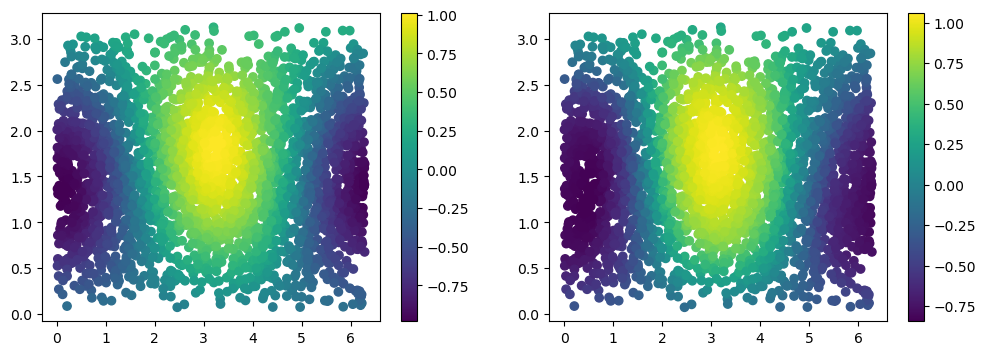

In [13]:
M_plot = 3000
x_plot = new_data(M_plot)
y_plot = threeto2D(x_plot)
z_plot = meta_learner(x_plot).detach().numpy()
z_l = learner(x_plot).detach().numpy()

plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_plot)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_l)
plt.colorbar()

print(f"MSE: {np.mean((z_l - z_plot)**2)}")

## Meta-Learn a second, orthogonal, function

In [14]:
# Data against which we'll measure orthogonality
M_orth = 1000
x_orth = new_data(M_orth)
z1 = meta_learner(x_orth).detach()

In [15]:
# Set up meta-learner
meta_learner_2 = MetaNet(input_size_gen, hidden_size_gen, output_size_gen, layers)
meta_optimizer = torch.optim.Adam(meta_learner_2.parameters(), lr = 0.01)

# Set up learning procedure
T = 200 # Number of meta steps
M = 300 # Test points per meta step
min_loss = 1000000
loss_entropy = SamplesLoss(loss="energy", p=2, blur=.05) 

for meta_step in range(T):
    meta_optimizer.zero_grad()

    # Set up new learner
    learner = LearnerNet(3, K, 1, 2)
    optimizer = torch.optim.Adam(learner.parameters(), lr=0.01)
    
    # Train it on a training set
    x = new_data(m)
    z = meta_learner_2(x)
    for i in range(t):
        optimizer.zero_grad()
        z_l = learner(x)
        
        loss = torch.mean((z - z_l)**2)
        g = torch.autograd.grad(loss, learner.parameters(), create_graph=True)
        learner = update_module(learner, list(map(lambda x: -eta*x, g)))
        #print(loss)
    
    
    # Measure generalisation error and distribution loss
    x_test = new_data(M)
    z_test = meta_learner_2(x_test)
    z_test_l = learner(x_test)
    z_orth = meta_learner_2(x_orth)
    distr = 2 * torch.rand(M, 1) - 1
    meta_loss = 100*torch.mean((z_test - z_test_l)**2) + 10000*loss_entropy(z_test, distr) + torch.sum(torch.multiply(z_orth, z1))**2
    meta_loss.backward()
    #print(list(NN.parameters())[0].grad)
    meta_optimizer.step()
    
    if meta_loss < min_loss:
        meta_learner2_best = meta_learner_2
        min_loss = meta_loss
    
    
    if meta_step % 50 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss}, Loss_g: {torch.mean((z_test - z_test_l)**2)}, Loss Orth: {torch.sum(torch.multiply(z_orth, z1))**2}")
        

Meta-Step: 0/200, Meta-Loss: 1587.929443359375, Loss_g: 0.0015263688983395696, Loss Orth: 6.391087055206299
Meta-Step: 50/200, Meta-Loss: 161.42507934570312, Loss_g: 0.011448205448687077, Loss Orth: 1.648451328277588
Meta-Step: 100/200, Meta-Loss: 21.464309692382812, Loss_g: 0.009006533771753311, Loss Orth: 0.5877547264099121
Meta-Step: 150/200, Meta-Loss: 86.18156433105469, Loss_g: 0.02536758966743946, Loss Orth: 0.46831831336021423


MSE: 0.04122285917401314


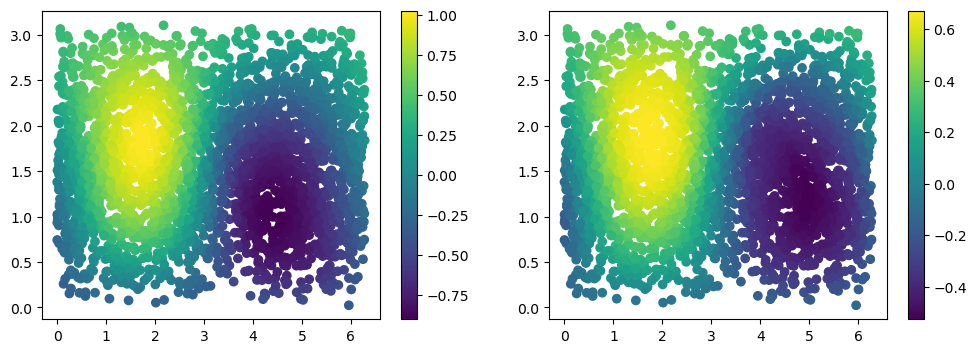

In [16]:
M_plot = 3000
x_plot = new_data(M_plot)
y_plot = threeto2D(x_plot)
z_plot = meta_learner2_best(x_plot).detach().numpy()
z_l = learner(x_plot).detach().numpy()

plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_plot)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_l)
plt.colorbar()

print(f"MSE: {np.mean((z_l - z_plot)**2)}")

And continue for all the 6 orthogonal functions

In [17]:
z2 = meta_learner2_best(x_orth).detach()

In [18]:
# Set up meta-learner
meta_learner3 = MetaNet(input_size_gen, hidden_size_gen, output_size_gen, layers)
meta_optimizer = torch.optim.Adam(meta_learner3.parameters(), lr = 0.01)

# Set up learning procedure
std_or_distr = 0 # std = 1
T = 300 # Number of meta steps
M = 300 # Test points per meta step
min_loss = 1000000

for meta_step in range(T):
    meta_optimizer.zero_grad()

    # Set up new learner
    learner = LearnerNet(3, K, 1, 2)
    optimizer = torch.optim.Adam(learner.parameters(), lr=0.01)
    
    # Train it on a training set
    x = new_data(m)
    z = meta_learner3(x)
    for i in range(t):
        optimizer.zero_grad()
        z_fly = learner(x)
        
        loss = torch.mean((z - z_fly)**2)
        g = torch.autograd.grad(loss, learner.parameters(), create_graph=True)
        learner = update_module(learner, list(map(lambda x: -eta*x, g)))
        #print(loss)
    
    
    # Measure generalisation error and distribution loss
    x_test = new_data(M)
    z_test = meta_learner3(x_test)
    z_test_fly = learner(x_test)
    z_orth = meta_learner3(x_orth)
    if std_or_distr == 1:
        meta_loss = 100*torch.mean((z_test - z_test_fly)**2) + 100*(torch.std(z_test) - 1)**2 + torch.sum(torch.multiply(z_orth, z1))**2 + torch.sum(torch.multiply(z_orth, z2))**2
    else:
        distr = 2 * torch.rand(M, 1) - 1
        meta_loss = 1000*torch.mean((z_test - z_test_fly)**2) + 10000*loss_entropy(z_test, distr) + torch.sum(torch.multiply(z_orth, z1))**2 + torch.sum(torch.multiply(z_orth, z2))**2
    meta_loss.backward()
    #print(list(NN.parameters())[0].grad)
    meta_optimizer.step()

    if meta_loss < min_loss:
        meta_learner3_best = meta_learner3
        min_loss = meta_loss
    
    if meta_step % 50 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss}, Loss_g: {torch.mean((z_test - z_test_fly)**2):.5f}, Loss Orth: {torch.sum(torch.multiply(z_orth, z1))**2:.3f}, Loss Orth 2: {torch.sum(torch.multiply(z_orth, z2))**2:.3f}")
        

Meta-Step: 0/300, Meta-Loss: 2440.090576171875, Loss_g: 0.00207, Loss Orth: 953.653, Loss Orth 2: 128.939
Meta-Step: 50/300, Meta-Loss: 111.29512023925781, Loss_g: 0.00955, Loss Orth: 4.549, Loss Orth 2: 6.286
Meta-Step: 100/300, Meta-Loss: 59.15620040893555, Loss_g: 0.01803, Loss Orth: 2.232, Loss Orth 2: 2.999
Meta-Step: 150/300, Meta-Loss: 33.08124542236328, Loss_g: 0.01093, Loss Orth: 0.128, Loss Orth 2: 0.661
Meta-Step: 200/300, Meta-Loss: 15.068424224853516, Loss_g: 0.00273, Loss Orth: 0.715, Loss Orth 2: 0.608
Meta-Step: 250/300, Meta-Loss: 11.624577522277832, Loss_g: 0.00390, Loss Orth: 0.169, Loss Orth 2: 0.146


MSE: 0.02744072489440441


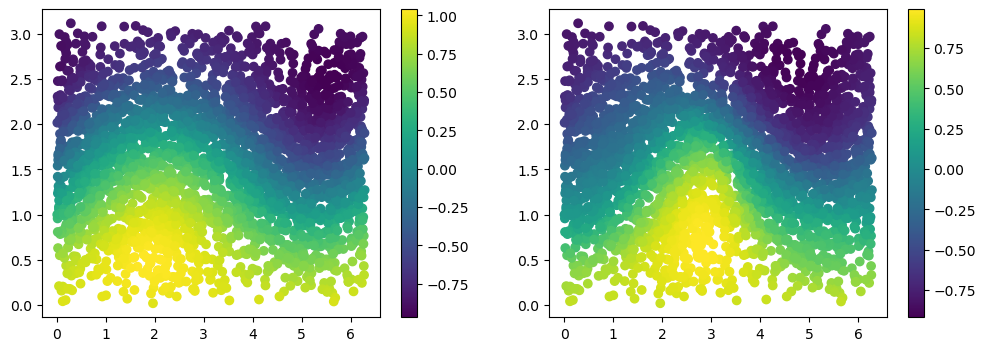

In [19]:
M_plot = 3000
x_plot = new_data(M_plot)
y_plot = threeto2D(x_plot)
z_plot = meta_learner3(x_plot).detach().numpy()
z_fly = learner(x_plot).detach().numpy()

plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_plot)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_fly)
plt.colorbar()

print(f"MSE: {np.mean((z_fly - z_plot)**2)}")

In [20]:
z3 = meta_learner3(x_orth).detach()

In [21]:
# Set up meta-learner
meta_learner4 = MetaNet(input_size_gen, hidden_size_gen, output_size_gen, layers)
meta_optimizer = torch.optim.Adam(meta_learner4.parameters(), lr = 0.01)

# Set up learning procedure
std_or_distr = 0 # std = 1
T = 750 # Number of meta steps
M = 300 # Test points per meta step
min_loss = 1000000

for meta_step in range(T):
    meta_optimizer.zero_grad()

    # Set up new fly
    learner = LearnerNet(3, K, 1, 2)
    optimizer = torch.optim.Adam(learner.parameters(), lr=0.01)
    
    # Train it on a training set
    x = new_data(m)
    z = meta_learner4(x)
    for i in range(t):
        optimizer.zero_grad()
        z_fly = learner(x)
        
        loss = torch.mean((z - z_fly)**2)
        g = torch.autograd.grad(loss, learner.parameters(), create_graph=True)
        learner = update_module(learner, list(map(lambda x: -eta*x, g)))
        #print(loss)
    
    
    # Measure generalisation error and distribution loss
    x_test = new_data(M)
    z_test = meta_learner4(x_test)
    z_test_fly = learner(x_test)
    z_orth = meta_learner4(x_orth)
    if std_or_distr == 1:
        meta_loss = 100*torch.mean((z_test - z_test_fly)**2) + 100*(torch.std(z_test) - 1)**2 + torch.sum(torch.multiply(z_orth, z1))**2 + torch.sum(torch.multiply(z_orth, z2))**2 + torch.sum(torch.multiply(z_orth, z3))**2
    else:
        distr = 2 * torch.rand(M, 1) - 1
        meta_loss = 1000*torch.mean((z_test - z_test_fly)**2) + 10000*loss_entropy(z_test, distr) + torch.sum(torch.multiply(z_orth, z1))**2 + torch.sum(torch.multiply(z_orth, z2))**2 + torch.sum(torch.multiply(z_orth, z3))**2
    meta_loss.backward()
    #print(list(NN.parameters())[0].grad)
    meta_optimizer.step()
    
    if meta_loss < min_loss:
        meta_learner4_best = meta_learner4
        min_loss = meta_loss
        
    if meta_step % 50 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss}, Loss_g: {torch.mean((z_test - z_test_fly)**2):.5f}, O: {torch.sum(torch.multiply(z_orth, z1))**2:.3f}, O 2: {torch.sum(torch.multiply(z_orth, z2))**2:.3f}, O 3: { + torch.sum(torch.multiply(z_orth, z3))**2:.3f}")
        

Meta-Step: 0/750, Meta-Loss: 1893.4124755859375, Loss_g: 0.00155, O: 2.390, O 2: 316.908, O 3: 34.910
Meta-Step: 50/750, Meta-Loss: 538.1569213867188, Loss_g: 0.08421, O: 10.900, O 2: 0.956, O 3: 5.111
Meta-Step: 100/750, Meta-Loss: 296.0595703125, Loss_g: 0.19700, O: 11.958, O 2: 0.382, O 3: 6.716
Meta-Step: 150/750, Meta-Loss: 306.8762512207031, Loss_g: 0.25171, O: 0.025, O 2: 0.121, O 3: 0.001
Meta-Step: 200/750, Meta-Loss: 309.5398254394531, Loss_g: 0.22788, O: 1.139, O 2: 0.173, O 3: 0.010
Meta-Step: 250/750, Meta-Loss: 303.33599853515625, Loss_g: 0.22394, O: 0.003, O 2: 0.397, O 3: 0.023
Meta-Step: 300/750, Meta-Loss: 268.74957275390625, Loss_g: 0.25921, O: 0.003, O 2: 0.001, O 3: 0.129
Meta-Step: 350/750, Meta-Loss: 247.89532470703125, Loss_g: 0.21168, O: 3.352, O 2: 1.467, O 3: 1.237
Meta-Step: 400/750, Meta-Loss: 286.7852783203125, Loss_g: 0.20277, O: 0.395, O 2: 0.352, O 3: 1.429
Meta-Step: 450/750, Meta-Loss: 290.0996398925781, Loss_g: 0.25206, O: 0.491, O 2: 0.016, O 3: 0.0

MSE: 0.23210282623767853


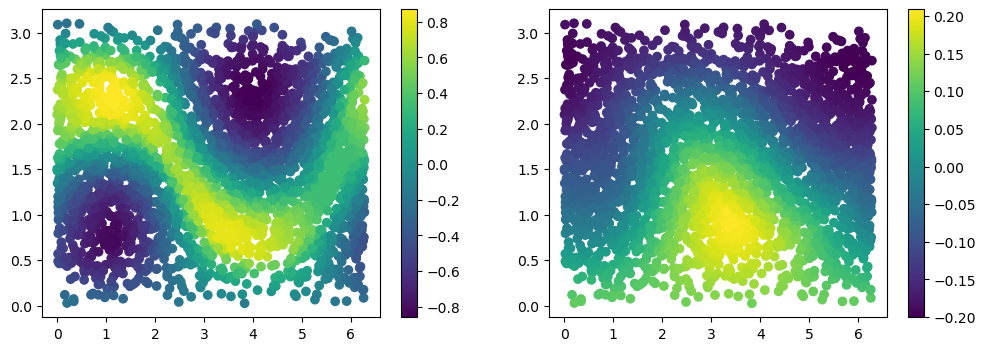

In [22]:
M_plot = 3000
x_plot = new_data(M_plot)
y_plot = threeto2D(x_plot)
z_plot = meta_learner4_best(x_plot).detach().numpy()
z_fly = learner(x_plot).detach().numpy()

plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_plot)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_fly)
plt.colorbar()

print(f"MSE: {np.mean((z_fly - z_plot)**2)}")

In [23]:
z4 = meta_learner4_best(x_orth).detach()

In [24]:
# Set up meta-learner
meta_learner5 = MetaNet(input_size_gen, hidden_size_gen, output_size_gen, layers)
meta_optimizer = torch.optim.Adam(meta_learner5.parameters(), lr = 0.01)

# Set up learning procedure
std_or_distr = 0 # std = 1
T = 750 # Number of meta steps
M = 300 # Test points per meta step
min_loss = 1000000

for meta_step in range(T):
    meta_optimizer.zero_grad()

    # Set up new fly
    learner = LearnerNet(3, K, 1, 2)
    optimizer = torch.optim.Adam(learner.parameters(), lr=0.01)
    
    # Train it on a training set
    x = new_data(m)
    z = meta_learner5(x)
    for i in range(t):
        optimizer.zero_grad()
        z_fly = learner(x)
        
        loss = torch.mean((z - z_fly)**2)
        g = torch.autograd.grad(loss, learner.parameters(), create_graph=True)
        learner = update_module(learner, list(map(lambda x: -eta*x, g)))
        #print(loss)
    
    
    # Measure generalisation error and distribution loss
    x_test = new_data(M)
    z_test = meta_learner5(x_test)
    z_test_fly = learner(x_test)
    z_orth = meta_learner5(x_orth)
    if std_or_distr == 1:
        meta_loss = 100*torch.mean((z_test - z_test_fly)**2) + 100*(torch.std(z_test) - 1)**2 + torch.sum(torch.multiply(z_orth, z1))**2 + torch.sum(torch.multiply(z_orth, z2))**2 + torch.sum(torch.multiply(z_orth, z3))**2 + torch.sum(torch.multiply(z_orth, z4))**2
    else:
        distr = 2 * torch.rand(M, 1) - 1
        meta_loss = 1000*torch.mean((z_test - z_test_fly)**2) + 10000*loss_entropy(z_test, distr) + torch.sum(torch.multiply(z_orth, z1))**2 + torch.sum(torch.multiply(z_orth, z2))**2 + torch.sum(torch.multiply(z_orth, z3))**2 + torch.sum(torch.multiply(z_orth, z4))**2
    meta_loss.backward()
    #print(list(NN.parameters())[0].grad)
    meta_optimizer.step()
    
    if meta_loss < min_loss:
        meta_learner5_best = meta_learner5
        min_loss = meta_loss
        
    if meta_step % 50 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss}, Loss_g: {torch.mean((z_test - z_test_fly)**2):.5f}, O: {torch.sum(torch.multiply(z_orth, z1))**2:.3f}, O 2: {torch.sum(torch.multiply(z_orth, z2))**2:.3f}, O 3: {torch.sum(torch.multiply(z_orth, z3))**2:.3f}, 0 4: {torch.sum(torch.multiply(z_orth, z3))**2:.3f}")
        

Meta-Step: 0/750, Meta-Loss: 2216.64208984375, Loss_g: 0.00072, O: 181.252, O 2: 29.953, O 3: 511.166, 0 4: 511.166
Meta-Step: 50/750, Meta-Loss: 1404.0537109375, Loss_g: 0.00187, O: 2.596, O 2: 2.055, O 3: 0.477, 0 4: 0.477
Meta-Step: 100/750, Meta-Loss: 313.3971862792969, Loss_g: 0.22475, O: 3.650, O 2: 0.115, O 3: 0.460, 0 4: 0.460
Meta-Step: 150/750, Meta-Loss: 222.0752410888672, Loss_g: 0.14944, O: 0.085, O 2: 0.242, O 3: 0.050, 0 4: 0.050
Meta-Step: 200/750, Meta-Loss: 292.7263488769531, Loss_g: 0.21308, O: 1.435, O 2: 0.116, O 3: 0.005, 0 4: 0.005
Meta-Step: 250/750, Meta-Loss: 253.0912628173828, Loss_g: 0.17100, O: 0.137, O 2: 5.475, O 3: 3.982, 0 4: 3.982
Meta-Step: 300/750, Meta-Loss: 248.666259765625, Loss_g: 0.19958, O: 0.395, O 2: 7.779, O 3: 0.429, 0 4: 0.429
Meta-Step: 350/750, Meta-Loss: 306.2327575683594, Loss_g: 0.24297, O: 0.035, O 2: 0.060, O 3: 0.102, 0 4: 0.102
Meta-Step: 400/750, Meta-Loss: 244.30104064941406, Loss_g: 0.17724, O: 2.188, O 2: 0.802, O 3: 0.143, 0 

MSE: 0.04500284418463707


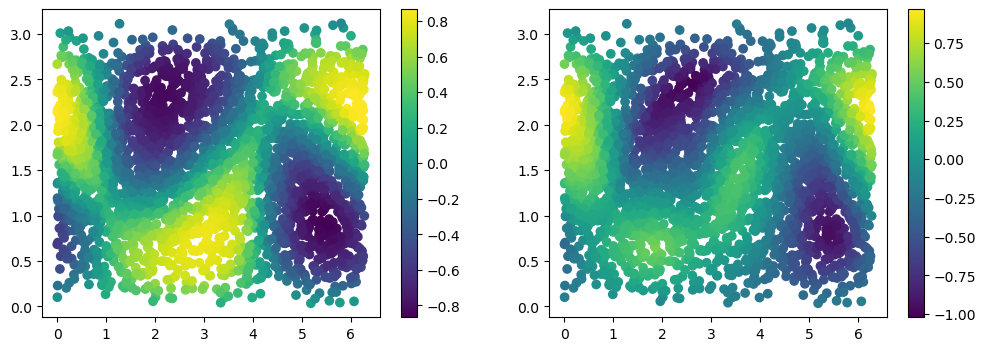

In [25]:
M_plot = 3000
x_plot = new_data(M_plot)
y_plot = threeto2D(x_plot)
z_plot = meta_learner5_best(x_plot).detach().numpy()

# Set up new fly
learner = LearnerNet(3, K, 1, 2)
optimizer = torch.optim.Adam(learner.parameters(), lr=0.01)

# Train it on a training set
x = new_data(m)
z = meta_learner5(x)
for i in range(2000):
    optimizer.zero_grad()
    z_fly = learner(x)

    loss = torch.mean((z - z_fly)**2)
    g = torch.autograd.grad(loss, learner.parameters(), create_graph=True)
    learner = update_module(learner, list(map(lambda x: -eta*x, g)))
    #print(loss)
z_fly = learner(x_plot).detach().numpy()

plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_plot)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_fly)
plt.colorbar()

print(f"MSE: {np.mean((z_fly - z_plot)**2)}")

In [26]:
z5 = meta_learner5_best(x_orth).detach()

In [27]:
# Set up meta-learner
meta_learner6 = MetaNet(input_size_gen, hidden_size_gen, output_size_gen, layers)
meta_optimizer = torch.optim.Adam(meta_learner6.parameters(), lr = 0.01)

# Set up learning procedure
std_or_distr = 0 # std = 1
T = 1000 # Number of meta steps
M = 300 # Test points per meta step
min_loss = 1000000

for meta_step in range(T):
    meta_optimizer.zero_grad()

    # Set up new fly
    learner = LearnerNet(3, K, 1, 2)
    optimizer = torch.optim.Adam(learner.parameters(), lr=0.01)
    
    # Train it on a training set
    x = new_data(m)
    z = meta_learner6(x)
    for i in range(t):
        optimizer.zero_grad()
        z_fly = learner(x)
        
        loss = torch.mean((z - z_fly)**2)
        g = torch.autograd.grad(loss, learner.parameters(), create_graph=True)
        learner = update_module(learner, list(map(lambda x: -eta*x, g)))
        #print(loss)
    
    
    # Measure generalisation error and distribution loss
    x_test = new_data(M)
    z_test = meta_learner6(x_test)
    z_test_fly = learner(x_test)
    z_orth = meta_learner6(x_orth)
    if std_or_distr == 1:
        meta_loss = 100*torch.mean((z_test - z_test_fly)**2) + 100*(torch.std(z_test) - 1)**2 + torch.sum(torch.multiply(z_orth, z1))**2 + torch.sum(torch.multiply(z_orth, z2))**2 + torch.sum(torch.multiply(z_orth, z3))**2 + torch.sum(torch.multiply(z_orth, z4))**2 + torch.sum(torch.multiply(z_orth, z5))**2
    else:
        distr = 2 * torch.rand(M, 1) - 1
        meta_loss = 1000*torch.mean((z_test - z_test_fly)**2) + 10000*loss_entropy(z_test, distr) + torch.sum(torch.multiply(z_orth, z1))**2 + torch.sum(torch.multiply(z_orth, z2))**2 + torch.sum(torch.multiply(z_orth, z3))**2 + torch.sum(torch.multiply(z_orth, z4))**2 + torch.sum(torch.multiply(z_orth, z5))**2
    meta_loss.backward()
    #print(list(NN.parameters())[0].grad)
    meta_optimizer.step()
    
    if meta_loss < min_loss:
        meta_learner6_best = meta_learner6
        min_loss = meta_loss
        
    if meta_step % 50 == 0:
        print(f"Meta-Step: {meta_step}/{T}, Meta-Loss: {meta_loss}, Loss_g: {torch.mean((z_test - z_test_fly)**2):.5f}, O: {torch.sum(torch.multiply(z_orth, z1))**2:.3f}, O 2: {torch.sum(torch.multiply(z_orth, z2))**2:.3f}, O 3: {torch.sum(torch.multiply(z_orth, z3))**2:.3f}, 0 4: {torch.sum(torch.multiply(z_orth, z4))**2:.3f}, O 5 {torch.sum(torch.multiply(z_orth, z5))**2}")
        

Meta-Step: 0/1000, Meta-Loss: 2107.873046875, Loss_g: 0.00235, O: 9.076, O 2: 93.265, O 3: 656.277, 0 4: 11.588, O 5 4.835327625274658
Meta-Step: 50/1000, Meta-Loss: 1686.0191650390625, Loss_g: 0.00047, O: 3.427, O 2: 0.080, O 3: 12.887, 0 4: 2.868, O 5 0.12344628572463989
Meta-Step: 100/1000, Meta-Loss: 1043.2847900390625, Loss_g: 0.02139, O: 0.433, O 2: 0.001, O 3: 1.276, 0 4: 0.093, O 5 0.03128012642264366
Meta-Step: 150/1000, Meta-Loss: 263.50225830078125, Loss_g: 0.21332, O: 10.438, O 2: 1.608, O 3: 3.738, 0 4: 0.032, O 5 0.07766219228506088
Meta-Step: 200/1000, Meta-Loss: 360.74615478515625, Loss_g: 0.21345, O: 0.018, O 2: 0.103, O 3: 0.006, 0 4: 0.013, O 5 0.30342093110084534
Meta-Step: 250/1000, Meta-Loss: 269.23223876953125, Loss_g: 0.17923, O: 2.285, O 2: 3.729, O 3: 1.143, 0 4: 2.753, O 5 0.5727198123931885
Meta-Step: 300/1000, Meta-Loss: 295.947021484375, Loss_g: 0.19507, O: 0.786, O 2: 0.035, O 3: 0.191, 0 4: 0.797, O 5 0.6500259637832642
Meta-Step: 350/1000, Meta-Loss: 26

MSE: 0.21584215760231018


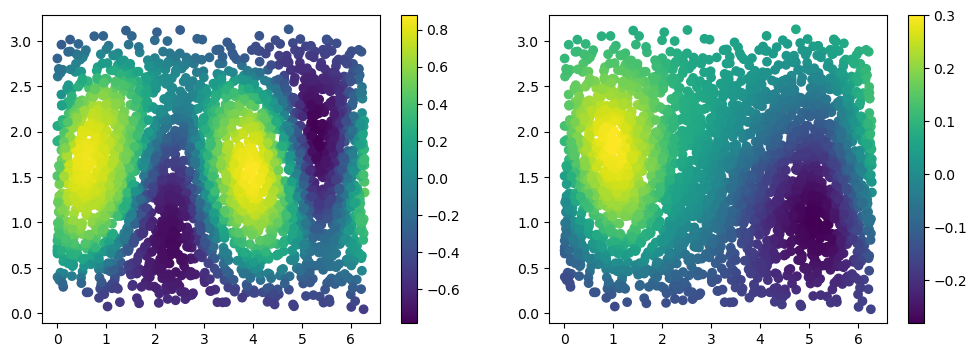

In [28]:
M_plot = 3000
x_plot = new_data(M_plot)
y_plot = threeto2D(x_plot)
z_plot = meta_learner6_best(x_plot).detach().numpy()
z_fly = learner(x_plot).detach().numpy()

plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_plot)
plt.colorbar()

plt.subplot(1,2,2)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z_fly)
plt.colorbar()

print(f"MSE: {np.mean((z_fly - z_plot)**2)}")

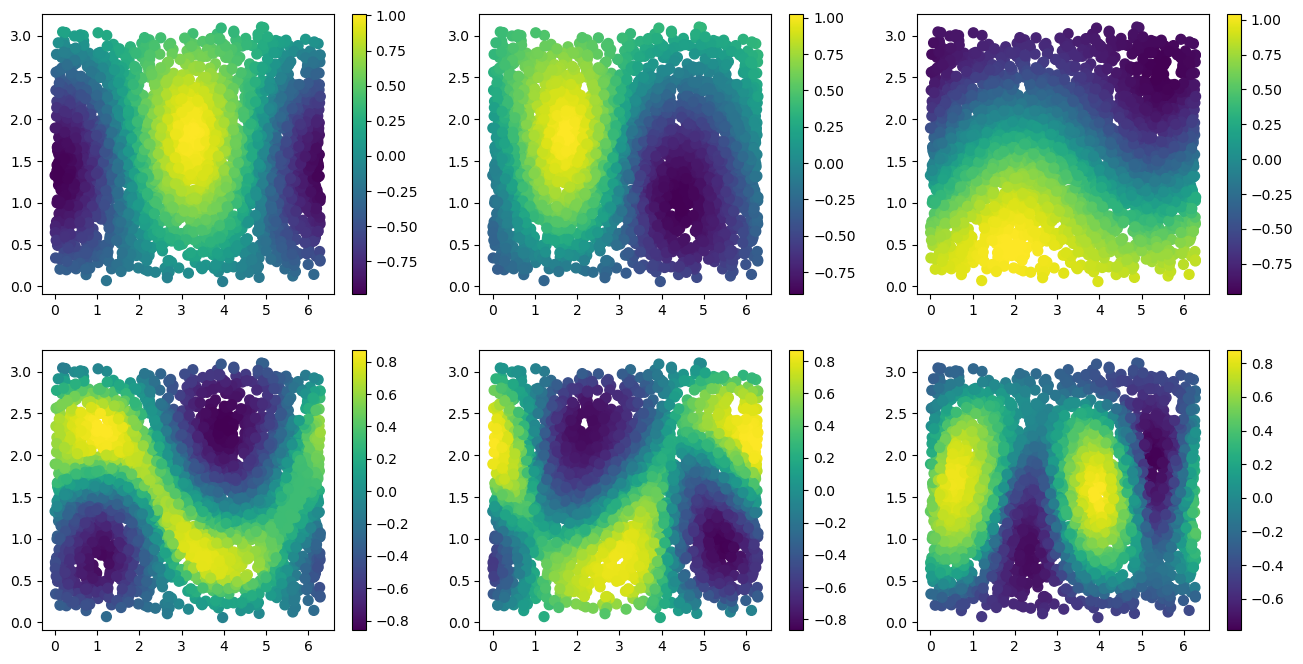

In [29]:
x_plot = new_data(3000)
y_plot = threeto2D(x_plot)
z1_plot = meta_learner(x_plot).detach().numpy()
z2_plot = meta_learner2_best(x_plot).detach().numpy()
z3_plot = meta_learner3_best(x_plot).detach().numpy()
z4_plot = meta_learner4_best(x_plot).detach().numpy()
z5_plot = meta_learner5_best(x_plot).detach().numpy()
z6_plot = meta_learner6_best(x_plot).detach().numpy()

plt.figure(figsize = (16,8))
plt.subplot(2,3,1)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z1_plot, s = 50)
plt.colorbar()

plt.subplot(2,3,2)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z2_plot, s = 50)
plt.colorbar()

plt.subplot(2,3,3)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z3_plot, s = 50)
plt.colorbar()

plt.subplot(2,3,4)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z4_plot, s = 50)
plt.colorbar()

plt.subplot(2,3,5)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z5_plot, s = 50)
plt.colorbar()

plt.subplot(2,3,6)
plt.scatter(y_plot[:,0], y_plot[:,1], c = z6_plot, s = 50)
plt.colorbar()

plt.savefig('Simple_BackProp_.svg')